In [1]:
import pandas as pd
from serialize import NumpyEncoder,json_numpy_obj_hook
import json
import orientation_converters as conv
from tqdm import tqdm
import math
from matplotlib import pyplot

In [2]:
with open("preds/alpha_normed.json","r+") as fp:
    alpha_preds = json.load(fp,object_hook=json_numpy_obj_hook)
with open("preds/rot_y_normed.json","r+") as fp:
    roty_preds = json.load(fp,object_hook=json_numpy_obj_hook)
with open("preds/single_bin_normed.json","r+") as fp:
    single_preds = json.load(fp,object_hook=json_numpy_obj_hook)
with open("preds/voting_bin_normed.json","r+") as fp:
    voting_preds = json.load(fp,object_hook=json_numpy_obj_hook)
with open("preds/tricosine_normed.json","r+") as fp:
    tricosine_preds = json.load(fp,object_hook=json_numpy_obj_hook)

In [3]:
sygyzy={}
for p in alpha_preds:
    pred_alpha = conv.angle_normed_to_radians(p['pred'][0])
    imgid = p['img']
    if (imgid not in sygyzy):
        sygyzy[imgid]={}
    sygyzy[imgid][p['line']] ={'norm_alpha':p['pred'][0],'pred_alpha':pred_alpha}
for p in roty_preds:
    pred_roty = conv.angle_normed_to_radians(p['pred'][0])
    imgid = p['img']
    if (imgid not in sygyzy):
        raise
    sygyzy[imgid][p['line']]['norm_roty'] = p['pred'][0]
    sygyzy[imgid][p['line']]['pred_roty'] = pred_roty
    tokens = p['line'].strip().split(' ')
    sygyzy[imgid][p['line']]['conv_roty'] = conv.rot_y_to_alpha(pred_roty,float(tokens[11]),float(tokens[13]))
    
for p in single_preds:
    conv_single = conv.single_bin_to_radians(p['pred'])
    imgid = p['img']
    if (imgid not in sygyzy):
        raise
    sygyzy[imgid][p['line']]['single_pred'] = p['pred']
    sygyzy[imgid][p['line']]['conv_single'] = conv_single
for p in voting_preds:
    conv_voting = conv.voting_bin_to_radians(p['pred'])
    imgid = p['img']
    if (conv_voting>math.pi):
        conv_voting-=math.tau
    if (imgid not in sygyzy):
        raise
    sygyzy[imgid][p['line']]['voting_pred'] = p['pred']
    sygyzy[imgid][p['line']]['conv_voting'] = conv_voting
for c,p in enumerate(tricosine_preds):
    conv_tri = conv.tricosine_to_radians(p['pred'])
    imgid = p['img']
    if (imgid not in sygyzy):
        raise
    sygyzy[imgid][p['line']]['tricosine_pred'] = p['pred']
    sygyzy[imgid][p['line']]['conv_tricosine'] = conv_tri

In [4]:
base = []
for c,imgid in enumerate(sygyzy):
    for instance in sygyzy[imgid]:
        work = sygyzy[imgid][instance]
        work['imgid'] = imgid
        work['line'] = instance
        tokens = instance.strip().split(' ')
        work['gt_alpha'] = float(tokens[3])
        work['gt_rot_y'] = float(tokens[14])
        work['class']=tokens[0]
        height = float(tokens[7])-float(tokens[5])
        occlusion = int(tokens[2])
        truncation = float(tokens[1])
        if (height>40 and occlusion<=0 and truncation<.15):
            work['difficulty'] = 'easy'
        elif (height>25 and occlusion<=1 and truncation<.3):
            work['difficulty'] = 'moderate'
        elif (height>25 and occlusion<=2 and truncation<.5):
            work['difficulty'] = 'hard'
        base.append(work)

In [5]:
df = pd.DataFrame(base)

In [6]:
from sklearn.metrics import precision_recall_curve,roc_auc_score
import numpy as np
import random
from statistics import mean

In [7]:
# alpha prediction
deltas = df['pred_alpha']-df['gt_alpha']
alpha_accuracy = (1+np.cos(deltas))/2
l = len(alpha_accuracy)
b = [c/l for c,i in enumerate(alpha_accuracy)]
aacc = [i for i in reversed(sorted(alpha_accuracy))]
mean(alpha_accuracy)

0.9555772751991275

In [8]:
#signle_bin
deltas = df['conv_single']-df['gt_alpha']
single_accuracy = (1+np.cos(deltas))/2
sacc = [i for i in reversed(sorted(single_accuracy))]
mean(single_accuracy)

0.9837125580616469

In [9]:
#voting_bin
deltas = df['conv_voting']-df['gt_alpha']
voting_accuracy = (1+np.cos(deltas))/2
vacc = [i for i in reversed(sorted(voting_accuracy))]
mean(voting_accuracy)

0.9805690578823568

In [10]:
#roty
deltas = df['conv_roty']-df['gt_alpha']
roty_accuracy = (1+np.cos(deltas))/2
yacc = [i for i in reversed(sorted(roty_accuracy ))]
mean(roty_accuracy )

0.935003204275589

In [11]:
#tricosine
deltas = df['conv_tricosine']-df['gt_alpha']
tri_accuracy = (1+np.cos(deltas))/2
tacc = [i for i in reversed(sorted(tri_accuracy))]
mean(tri_accuracy)

0.9817578436715577

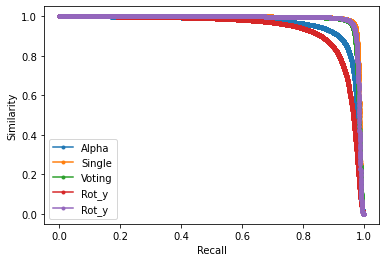

In [12]:
pyplot.plot(b, aacc, marker='.', label='Alpha')
pyplot.plot(b, sacc, marker='.', label='Single')
pyplot.plot(b, vacc, marker='.', label='Voting')
pyplot.plot(b, yacc, marker='.', label='Rot_y')
pyplot.plot(b, tacc, marker='.', label='Rot_y')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Similarity')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [13]:
easy =  df.loc[(df['difficulty'] == 'easy')]
mod =  df.loc[(df['difficulty'] == 'moderate')]
hard =  df.loc[(df['difficulty'] == 'hard')]

0.961463820782948
0.9860667423416488
0.9805088052073231
0.9345259157344845
0.9814403796984776


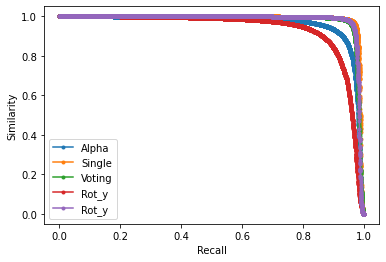

In [14]:
# alpha prediction
deltas = easy['pred_alpha']-easy['gt_alpha']
alpha_accuracy = (1+np.cos(deltas))/2
l = len(alpha_accuracy)
b = [c/l for c,i in enumerate(alpha_accuracy)]
aacc = [i for i in reversed(sorted(alpha_accuracy))]
print(mean(alpha_accuracy))
#signle_bin
deltas = easy['conv_single']-easy['gt_alpha']
single_accuracy = (1+np.cos(deltas))/2
sacc = [i for i in reversed(sorted(single_accuracy))]
print(mean(single_accuracy))
#voting_bin
deltas = easy['conv_voting']-easy['gt_alpha']
voting_accuracy = (1+np.cos(deltas))/2
vacc = [i for i in reversed(sorted(voting_accuracy))]
print(mean(voting_accuracy))
#roty
deltas = easy['conv_roty']-easy['gt_alpha']
roty_accuracy = (1+np.cos(deltas))/2
yacc = [i for i in reversed(sorted(roty_accuracy ))]
print(mean(roty_accuracy ))
#tricosine
deltas = easy['conv_tricosine']-easy['gt_alpha']
tri_accuracy = (1+np.cos(deltas))/2
tacc = [i for i in reversed(sorted(tri_accuracy))]
print(mean(tri_accuracy))
pyplot.plot(b, aacc, marker='.', label='Alpha')
pyplot.plot(b, sacc, marker='.', label='Single')
pyplot.plot(b, vacc, marker='.', label='Voting')
pyplot.plot(b, yacc, marker='.', label='Rot_y')
pyplot.plot(b, tacc, marker='.', label='Rot_y')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Similarity')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

0.9374666665906349
0.9758941966139293
0.9738647756683352
0.9164442373636534
0.9766073963412087


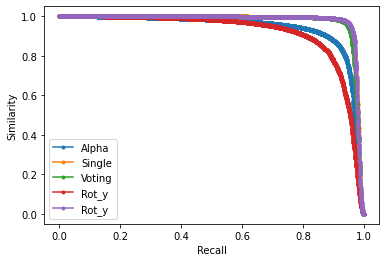

In [15]:
# alpha prediction
deltas = hard['pred_alpha']-hard['gt_alpha']
alpha_accuracy = (1+np.cos(deltas))/2
l = len(alpha_accuracy)
b = [c/l for c,i in enumerate(alpha_accuracy)]
aacc = [i for i in reversed(sorted(alpha_accuracy))]
print(mean(alpha_accuracy))
#signle_bin
deltas = hard['conv_single']-hard['gt_alpha']
single_accuracy = (1+np.cos(deltas))/2
sacc = [i for i in reversed(sorted(single_accuracy))]
print(mean(single_accuracy))
#voting_bin
deltas = hard['conv_voting']-hard['gt_alpha']
voting_accuracy = (1+np.cos(deltas))/2
vacc = [i for i in reversed(sorted(voting_accuracy))]
print(mean(voting_accuracy))
#roty
deltas = hard['conv_roty']-hard['gt_alpha']
roty_accuracy = (1+np.cos(deltas))/2
yacc = [i for i in reversed(sorted(roty_accuracy ))]
print(mean(roty_accuracy ))
#tricosine
deltas = hard['conv_tricosine']-hard['gt_alpha']
tri_accuracy = (1+np.cos(deltas))/2
tacc = [i for i in reversed(sorted(tri_accuracy))]
print(mean(tri_accuracy))
pyplot.plot(b, aacc, marker='.', label='Alpha')
pyplot.plot(b, sacc, marker='.', label='Single')
pyplot.plot(b, vacc, marker='.', label='Voting')
pyplot.plot(b, yacc, marker='.', label='Rot_y')
pyplot.plot(b, tacc, marker='.', label='Rot_y')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Similarity')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [16]:
def get_class_diff(css,diff):
    return df.loc[(df['difficulty'] == css) & (df['class']==diff)]
def getPlot(data,metric):
    print(data.size)
    deltas = data[metric]-data['gt_alpha']
    acc = (1+np.cos(deltas))/2
    return [i for i in reversed(sorted(acc))], [i/acc.size for i in range(acc.size)]

In [17]:
easy_cars = df.loc[(df['difficulty'] == 'easy') & (df['class']=='Car')]
mod_cars = df.loc[((df['difficulty'] == 'moderate') | (df['difficulty'] == 'easy'))& (df['class']=='Car')]
hard_cars = df.loc[((df['difficulty'] == 'hard')|(df['difficulty'] == 'moderate') | (df['difficulty'] == 'easy')) & (df['class']=='Car')]
x1,y1=getPlot(easy_cars,'conv_roty')
print("Easy acc %f, %d elements"%(mean(x1),len(x1)))
x2,y2=getPlot(mod_cars,'conv_roty')
print("Med acc %f, %d elements"%(mean(x2),len(x2)))
x3,y3=getPlot(hard_cars,'conv_roty')
print("Hard acc %f, %d elements"%(mean(x3),len(x3)))

101099
Easy acc 0.965910, 5947 elements
263313
Med acc 0.963851, 15489 elements
364514
Hard acc 0.954115, 21442 elements


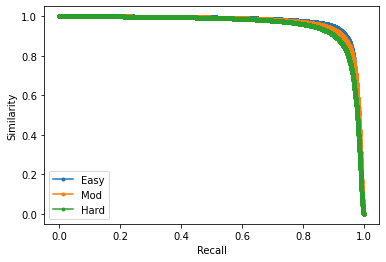

In [18]:
pyplot.plot(y1, x1, marker='.', label='Easy')
pyplot.plot(y2, x2, marker='.', label='Mod')
pyplot.plot(y3, x3, marker='.', label='Hard')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Similarity')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [19]:
easy_cars = df.loc[(df['difficulty'] == 'easy') & (df['class']=='Pedestrian')]
mod_cars = df.loc[((df['difficulty'] == 'moderate') | (df['difficulty'] == 'easy'))& (df['class']=='Pedestrian')]
hard_cars = df.loc[((df['difficulty'] == 'hard')|(df['difficulty'] == 'moderate') | (df['difficulty'] == 'easy')) & (df['class']=='Pedestrian')]
x1,y1=getPlot(easy_cars,'conv_roty')
print("Easy acc %f, %d elements"%(mean(x1),len(x1)))
x2,y2=getPlot(mod_cars,'conv_roty')
print("Med acc %f, %d elements"%(mean(x2),len(x2)))
x3,y3=getPlot(hard_cars,'conv_roty')
print("Hard acc %f, %d elements"%(mean(x3),len(x3)))

39168
Easy acc 0.860084, 2304 elements
60486
Med acc 0.856382, 3558 elements
72573
Hard acc 0.850570, 4269 elements


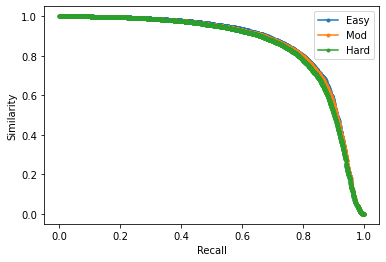

In [20]:
pyplot.plot(y1, x1, marker='.', label='Easy')
pyplot.plot(y2, x2, marker='.', label='Mod')
pyplot.plot(y3, x3, marker='.', label='Hard')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Similarity')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [21]:
easy_cars = df.loc[(df['difficulty'] == 'easy') & (df['class']=='Cyclist')]
mod_cars = df.loc[((df['difficulty'] == 'moderate') | (df['difficulty'] == 'easy'))& (df['class']=='Cyclist')]
hard_cars = df.loc[((df['difficulty'] == 'hard')|(df['difficulty'] == 'moderate') | (df['difficulty'] == 'easy')) & (df['class']=='Cyclist')]
x1,y1=getPlot(easy_cars,'conv_roty')
print("Easy acc %f, %d elements"%(mean(x1),len(x1)))
x2,y2=getPlot(mod_cars,'conv_roty')
print("Med acc %f, %d elements"%(mean(x2),len(x2)))
x3,y3=getPlot(hard_cars,'conv_roty')
print("Hard acc %f, %d elements"%(mean(x3),len(x3)))

11050
Easy acc 0.911252, 650 elements
18547
Med acc 0.898990, 1091 elements
20179
Hard acc 0.895397, 1187 elements


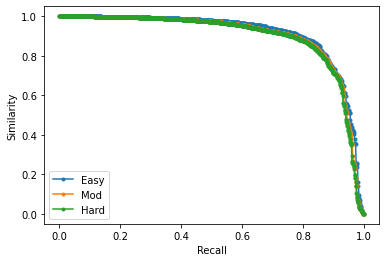

In [22]:
pyplot.plot(y1, x1, marker='.', label='Easy')
pyplot.plot(y2, x2, marker='.', label='Mod')
pyplot.plot(y3, x3, marker='.', label='Hard')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Similarity')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()